In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm.notebook import tqdm

In [22]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir0:str, path_dir1:str):
        super().__init__()

        self.path_dir0 = path_dir0
        self.path_dir1 = path_dir1

        self.dir0_list = sorted(os.listdir(path_dir0))
        self.dir1_list = sorted(os.listdir(path_dir1))

    def __len__(self):
        return len(self.dir0_list) + len(self.dir1_list)
    
    def __getitem__(self, idx):
        if idx < len(self.dir0_list):
            class_id = 0
            img_path = os.path.join(self.path_dir0, self.dir0_list[idx])
        else:
            idx -= len(self.dir1_list)
            class_id = 1
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img / 255.0
        img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)

        img = img.transpose((2, 0, 1))
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)

        return {'img' : t_img, 'label' : t_class_id}



In [23]:
train_dogs_path = '/Users/vladimirberman/Documents/ML/trainings/dlcourseai/dlcourse_ai/my_tests/datasets/cats_dogs/training_set/dogs'
train_cats_path = '/Users/vladimirberman/Documents/ML/trainings/dlcourseai/dlcourse_ai/my_tests/datasets/cats_dogs/training_set/cats'

test_dogs_path = '/Users/vladimirberman/Documents/ML/trainings/dlcourseai/dlcourse_ai/my_tests/datasets/cats_dogs/test_set/dogs'
test_cats_path = '/Users/vladimirberman/Documents/ML/trainings/dlcourseai/dlcourse_ai/my_tests/datasets/cats_dogs/test_set/cats'

train_ds_cats_dogs = Dataset2class(train_dogs_path, train_cats_path)
test_ds_cats_dogs = Dataset2class(test_dogs_path, test_cats_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


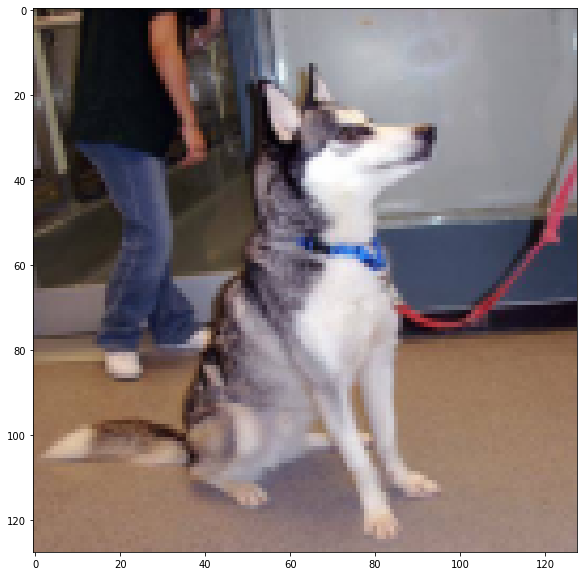

In [24]:
plt.figure(figsize = (10,10))
plt.imshow(test_ds_cats_dogs[0]['img'].numpy().transpose((1,2,0)))

In [25]:
train_ds_cats_dogs[0]['img']

tensor([[[0.7557, 0.5819, 0.6345,  ..., 0.4309, 0.4439, 0.3951],
         [0.7401, 0.5097, 0.5539,  ..., 0.4072, 0.4397, 0.4004],
         [0.6727, 0.4083, 0.4225,  ..., 0.4118, 0.4221, 0.3591],
         ...,
         [0.9871, 0.9593, 0.9592,  ..., 0.9178, 0.9200, 0.9111],
         [0.9907, 0.9554, 0.9448,  ..., 0.9314, 0.9212, 0.9081],
         [0.9962, 0.9764, 0.9684,  ..., 0.9513, 0.9561, 0.9487]],

        [[0.6747, 0.4498, 0.4833,  ..., 0.3096, 0.3237, 0.2748],
         [0.6337, 0.3412, 0.3502,  ..., 0.2797, 0.3167, 0.2773],
         [0.6112, 0.2735, 0.2419,  ..., 0.3107, 0.3190, 0.2560],
         ...,
         [0.9804, 0.9545, 0.9577,  ..., 0.9138, 0.9190, 0.9102],
         [0.9802, 0.9445, 0.9380,  ..., 0.9326, 0.9290, 0.9160],
         [0.9951, 0.9761, 0.9722,  ..., 0.9549, 0.9610, 0.9535]],

        [[0.5988, 0.3370, 0.3482,  ..., 0.2204, 0.2389, 0.1902],
         [0.5373, 0.1990, 0.1779,  ..., 0.1716, 0.2108, 0.1716],
         [0.5542, 0.1577, 0.0828,  ..., 0.1927, 0.2046, 0.

In [26]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
   train_ds_cats_dogs, shuffle=True, 
    batch_size=batch_size, num_workers=0, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_ds_cats_dogs, shuffle=True,
    batch_size=batch_size, num_workers=0, drop_last=False
)

In [27]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv0 = nn.Conv2d(3, 128, 3, stride = 1, padding = 0)
        self.conv1 = nn.Conv2d(128, 128, 3, stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(128, 128, 3, stride = 1, padding = 0)
        self.conv3 = nn.Conv2d(128, 256, 3, stride = 1, padding = 0)

        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(256, 20)
        self.linear2 = nn.Linear(20, 2)




    def forward(self, x):
        
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.act(out)

        out = self.adaptivepool(out)
        out = self.flat(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out

In [28]:
model = ConvNet()

In [29]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

599102

In [30]:
loss_fn = nn.CrossEntropyLoss()

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas = (0.9, 0.999))

In [32]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    return answer.mean()

In [33]:
for sample in train_loader:
    img = sample['img']
    label = sample['label']
    model(img)
    break

In [45]:
epochs = 10
loss_list = []
ac_list = []
for epoch in range(epochs):
    loss_val = 0
    ac_val = 0
    for samplel in (pbar := tqdm(train_loader)):
        img = sample['img']
        label = sample['label']
        optimizer.zero_grad()
        label = nn.functional.one_hot(label, 2).float()
        pred = model(img)
        loss = loss_fn(pred, label)
        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item
        optimizer.step()
        ac_current = accuracy(pred, label)
        pbar.set_description(f'loss: {loss_item: .4f}')
    loss_list.append(loss_val / len(train_ds_cats_dogs))
    ac_list.append(ac_current)
    

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_19356/1416373963.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


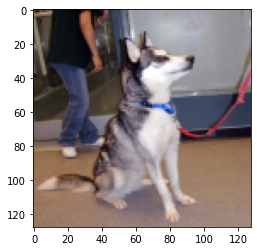

In [36]:
plt.imshow(test_ds_cats_dogs[0]['img'].numpy().transpose((1,2,0)))

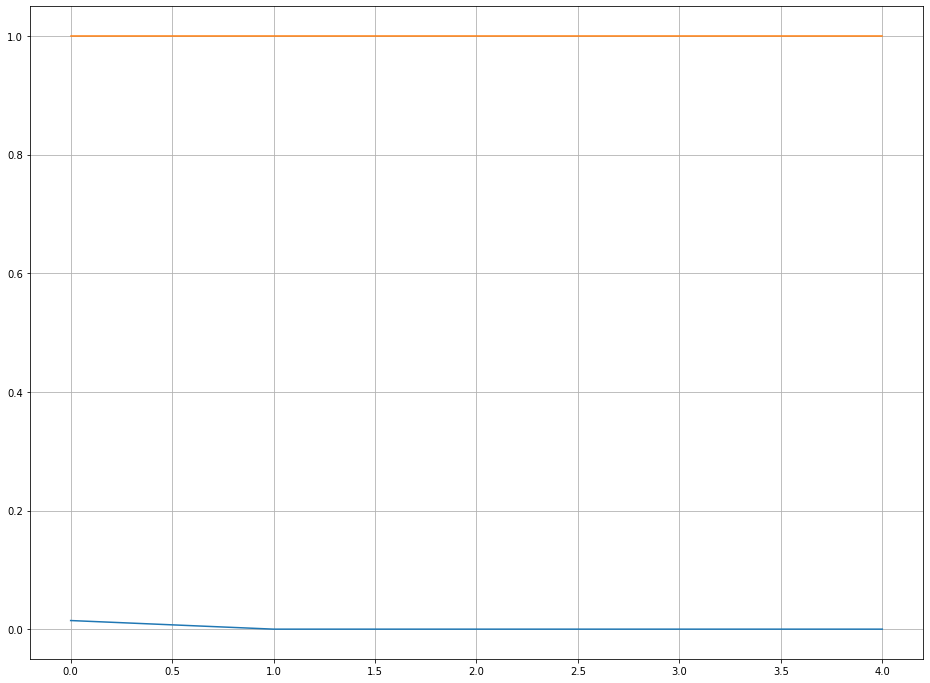

In [46]:
plt.figure(figsize=(16, 12))
plt.plot(np.arange(5), np.array(loss_list))
plt.plot(np.arange(5), np.array(ac_list))
plt.grid(True)

In [47]:
ac_list

[1.0, 1.0, 1.0, 1.0, 1.0]

In [48]:
loss_val = 0
acc_val = 0
for sample in (pbar := tqdm(test_loader)):
    with torch.no_grad():
        img, label = sample['img'], sample['label']

        label = F.one_hot(label, 2).float()
        pred = model(img)

        loss = loss_fn(pred, label)
        loss_item = loss.item()
        loss_val += loss_item

        acc_current = accuracy(pred, label)
        acc_val += acc_current

    pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')


  0%|          | 0/125 [00:00<?, ?it/s]

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_19356/1416373963.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)


In [49]:
print(loss_val/len(test_loader))
print(acc_val/len(test_loader))

6.343851040601731
0.5795


In [44]:
loss_val = 0
acc_val = 0
for sample in (pbar := tqdm(train_loader)):
    with torch.no_grad():
        img, label = sample['img'], sample['label']

        label = F.one_hot(label, 2).float()
        pred = model(img)

        loss = loss_fn(pred, label)
        loss_item = loss.item()
        loss_val += loss_item

        acc_current = accuracy(pred, label)
        acc_val += acc_current

    pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_19356/1416373963.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)


In [50]:
def pow(a, n):
	if n  == 1:
		return a
	# if n == 0:
	# 	return 1
	b = pow(a, n // 2)
	b *= b
	if n % 2 == 1:
		b *= a
	return b